In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Define dataset path
base_dir = r"E:\Collaboration Work\With Farooq\Bearings MDPI\CWT_Log\For Channel-02"
class_labels = ['Inner', 'Outer', 'Roller', 'Normal']

# Image transformation (resize + normalize)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1,1]
])

# Custom Dataset Loader
class BearingCWT_Dataset(Dataset):
    def __init__(self, base_dir, class_labels, transform=None):
        self.transform = transform
        self.data = []
        self.labels = []
        
        for label_idx, class_name in enumerate(class_labels):
            class_path = os.path.join(base_dir, f"{class_name} (1800)")
            image_files = [f for f in os.listdir(class_path) if f.endswith('.png') or f.endswith('.jpg')]
            
            for image_file in image_files[:500]:  # Load a subset
                img_path = os.path.join(class_path, image_file)
                image = Image.open(img_path).convert('L')  # Convert to grayscale
                
                if self.transform:
                    image = self.transform(image)
                
                self.data.append(image)
                self.labels.append(label_idx)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Load dataset
dataset = BearingCWT_Dataset(base_dir, class_labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Check sample shape
sample_img, sample_label = next(iter(dataloader))
print("Sample Image Shape:", sample_img.shape)  # Expect (Batch, 1, 128, 128)
print("Sample Label:", sample_label[:5])


Sample Image Shape: torch.Size([32, 1, 128, 128])
Sample Label: tensor([0, 1, 0, 2, 2])


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class CNN_ResNet(nn.Module):
    def __init__(self):
        super(CNN_ResNet, self).__init__()
        
        # CNN Feature Extraction
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        # Adaptive Pooling to Reduce Feature Map Size
        self.global_pool = nn.AdaptiveAvgPool2d((16, 16))  # Reduces spatial size

        # Multi-Head Attention (Reduce embedding size to 64)
        self.attn_q = nn.Linear(64, 64)
        self.attn_k = nn.Linear(64, 64)
        self.attn_v = nn.Linear(64, 64)
        self.attn = nn.MultiheadAttention(embed_dim=64, num_heads=4, batch_first=True)

        # Bi-LSTM (Input size adjusted)
        self.lstm = nn.LSTM(input_size=64, hidden_size=128, num_layers=2, bidirectional=True, batch_first=True)

        # Fully Connected Layer
        self.fc1 = nn.Linear(128 * 2, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 4)  # 4 classes

    def forward(self, x):
        # CNN Feature Extraction
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        # Apply Adaptive Pooling to Reduce Feature Map Size
        x = self.global_pool(x)  # Shape: (batch, 64, 16, 16)

        # Flatten spatial dimensions for attention
        batch_size, channels, height, width = x.shape
        x = x.view(batch_size, height * width, channels)  # Shape: (batch, 256, 64)

        # Multi-Head Attention
        q, k, v = self.attn_q(x), self.attn_k(x), self.attn_v(x)
        x, _ = self.attn(q, k, v)

        # Bi-LSTM
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Take last timestep

        # Fully Connected Layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return x

# Initialize Model
model = CNN_ResNet()



In [3]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)




In [ ]:
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

KeyboardInterrupt: 

In [11]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            outputs = model(batch_X)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Run Evaluation
evaluate_model(model, dataloader)


Test Accuracy: 80.95%


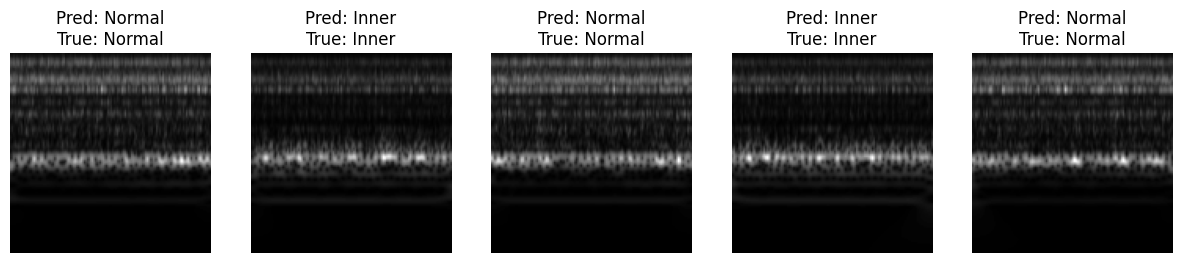

In [12]:
import matplotlib.pyplot as plt

# Get a batch of test images
batch_X, batch_y = next(iter(dataloader))
outputs = model(batch_X)
_, predicted = torch.max(outputs, 1)

# Plot 5 images with predictions
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = batch_X[i].squeeze().numpy()
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Pred: {class_labels[predicted[i].item()]}\nTrue: {class_labels[batch_y[i].item()]}")
    axes[i].axis('off')

plt.show()


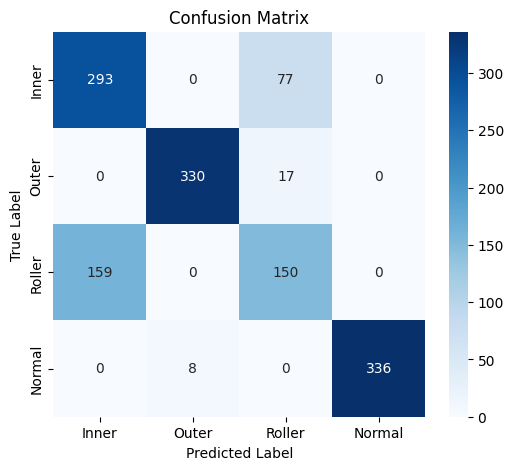

Classification Report:
               precision    recall  f1-score   support

       Inner       0.65      0.79      0.71       370
       Outer       0.98      0.95      0.96       347
      Roller       0.61      0.49      0.54       309
      Normal       1.00      0.98      0.99       344

    accuracy                           0.81      1370
   macro avg       0.81      0.80      0.80      1370
weighted avg       0.81      0.81      0.81      1370



In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate Model & Collect Predictions
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in dataloader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# Compute Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=class_labels)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:\n", report)


In [14]:
def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []
    
    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            batch_X = batch_X.to(torch.device("cpu"))  # Ensure CPU execution
            
            # Pass through CNN
            x = model.conv1(batch_X)
            x = model.bn1(x)
            x = model.relu(x)
            x = model.conv2(x)
            x = model.bn2(x)
            x = model.relu(x)
            x = model.global_pool(x)  # Adaptive Pooling to reduce spatial size
            
            # Flatten spatial dimensions
            batch_size, channels, height, width = x.shape
            x = x.view(batch_size, height * width, channels)  # Shape: (batch, seq_len, feature_dim)
            
            # Multi-Head Attention
            q, k, v = model.attn_q(x), model.attn_k(x), model.attn_v(x)
            x, _ = model.attn(q, k, v)  # Corrected attention pass
            
            # LSTM
            x, _ = model.lstm(x)
            x = x[:, -1, :]  # Take last timestep
            
            # Extract Features from Fully Connected Layer
            feature_vector = model.fc1(x)
            features.extend(feature_vector.cpu().numpy())
            labels.extend(batch_y.cpu().numpy())
    
    return np.array(features), np.array(labels)



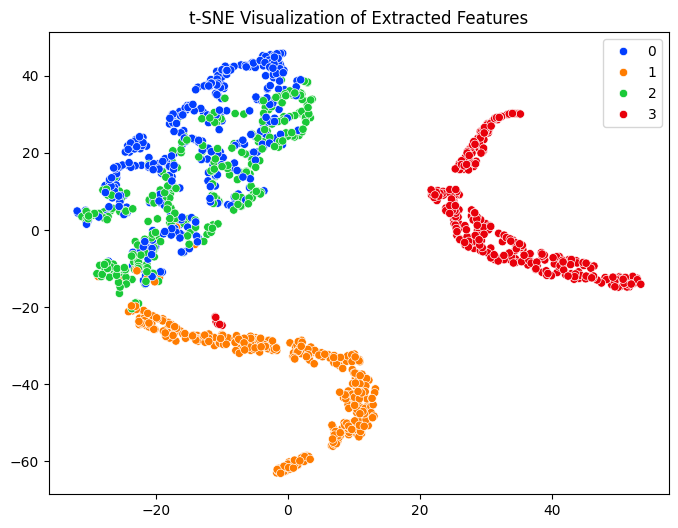

In [15]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Extract Features
features, tsne_labels = extract_features(model, dataloader)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(features)

# Plot t-SNE
plt.figure(figsize=(8,6))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=tsne_labels, palette="bright", legend='full')
plt.title("t-SNE Visualization of Extracted Features")
plt.show()


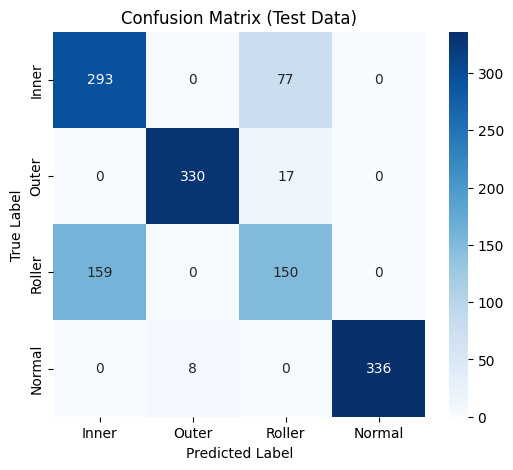

Classification Report:
               precision    recall  f1-score   support

       Inner       0.65      0.79      0.71       370
       Outer       0.98      0.95      0.96       347
      Roller       0.61      0.49      0.54       309
      Normal       1.00      0.98      0.99       344

    accuracy                           0.81      1370
   macro avg       0.81      0.80      0.80      1370
weighted avg       0.81      0.81      0.81      1370



In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import confusion_matrix, classification_report

# Ensure model is in evaluation mode
model.eval()

# Store predictions & true labels
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch_X, batch_y in dataloader:  # Use test dataloader
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)  # Get class with highest probability
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# Compute Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=class_labels)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Data)")
plt.show()

# Print Classification Report
print("Classification Report:\n", report)


In [17]:
import os

# Define dataset path
base_dir = r"E:\Collaboration Work\With Farooq\Bearings MDPI\CWT_Log\For Channel-02"
class_labels = ['Inner', 'Outer', 'Roller', 'Normal']

# Count total images in dataset
total_samples = 0
class_sample_counts = {}

for class_name in class_labels:
    class_path = os.path.join(base_dir, f"{class_name} (1800)")
    num_files = len([f for f in os.listdir(class_path) if f.endswith('.png') or f.endswith('.jpg')])
    class_sample_counts[class_name] = num_files
    total_samples += num_files

# Print total samples
print(f"Total Samples: {total_samples}")
print("Samples per Class:", class_sample_counts)


Total Samples: 1370
Samples per Class: {'Inner': 370, 'Outer': 347, 'Roller': 309, 'Normal': 344}


In [18]:
# Define train-test split ratio (adjust if different)
train_ratio = 0.8  # 80% train, 20% test

train_samples = int(total_samples * train_ratio)
test_samples = total_samples - train_samples

print(f"Train Samples: {train_samples}")
print(f"Test Samples: {test_samples}")


Train Samples: 1096
Test Samples: 274


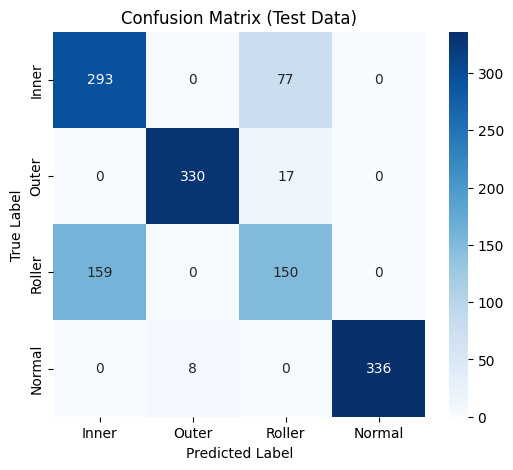

Classification Report:
               precision    recall  f1-score   support

       Inner       0.65      0.79      0.71       370
       Outer       0.98      0.95      0.96       347
      Roller       0.61      0.49      0.54       309
      Normal       1.00      0.98      0.99       344

    accuracy                           0.81      1370
   macro avg       0.81      0.80      0.80      1370
weighted avg       0.81      0.81      0.81      1370



In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Ensure model is in evaluation mode
model.eval()

# Store test set predictions & true labels
test_preds = []
test_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch_X, batch_y in dataloader:  # Use only test dataloader
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)  # Get highest probability class
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(batch_y.cpu().numpy())

# Compute Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
report = classification_report(test_labels, test_preds, target_names=class_labels)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Data)")
plt.show()

# Print Classification Report
print("Classification Report:\n", report)


In [ ]:
print(f"Total t-SNE Samples Plotted: {len(tsne_results)}")


In [20]:
def extract_test_features(model, test_dataloader):
    model.eval()
    test_features = []
    test_labels = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_dataloader:  # Use only test set
            batch_X = batch_X.to(torch.device("cpu"))  # Ensure CPU execution
            
            # CNN Feature Extraction
            x = model.conv1(batch_X)
            x = model.bn1(x)
            x = model.relu(x)
            x = model.conv2(x)
            x = model.bn2(x)
            x = model.relu(x)
            x = model.global_pool(x)  # Adaptive Pooling to reduce spatial size
            
            # Flatten spatial dimensions
            batch_size, channels, height, width = x.shape
            x = x.view(batch_size, height * width, channels)  # Shape: (batch, seq_len, feature_dim)
            
            # Multi-Head Attention
            q, k, v = model.attn_q(x), model.attn_k(x), model.attn_v(x)
            x, _ = model.attn(q, k, v)
            
            # LSTM
            x, _ = model.lstm(x)
            x = x[:, -1, :]  # Take last timestep
            
            # Extract Features from Fully Connected Layer
            feature_vector = model.fc1(x)
            test_features.extend(feature_vector.cpu().numpy())
            test_labels.extend(batch_y.cpu().numpy())
    
    return np.array(test_features), np.array(test_labels)


In [21]:
from torch.utils.data import random_split, DataLoader

# Define train-test split ratio
train_ratio = 0.8  # 80% train, 20% test
test_ratio = 1 - train_ratio

# Calculate split sizes
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# Split dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)



Total t-SNE Test Samples Plotted: 274


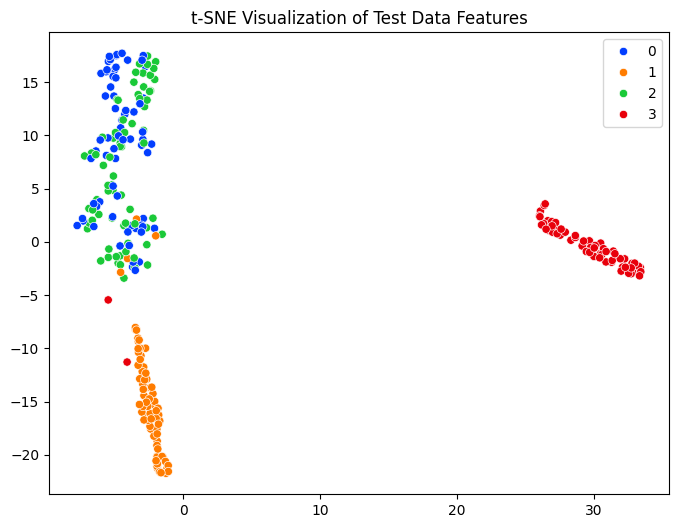

In [22]:
# Extract Only Test Features
test_features, test_tsne_labels = extract_test_features(model, test_dataloader)

# Check the correct number of test samples
print(f"Total t-SNE Test Samples Plotted: {len(test_features)}")  # Should be 274

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results_test = tsne.fit_transform(test_features)

# Plot t-SNE for Test Data
plt.figure(figsize=(8,6))
sns.scatterplot(x=tsne_results_test[:,0], y=tsne_results_test[:,1], hue=test_tsne_labels, palette="bright", legend='full')
plt.title("t-SNE Visualization of Test Data Features")
plt.show()


Total t-SNE Test Samples Plotted: 274


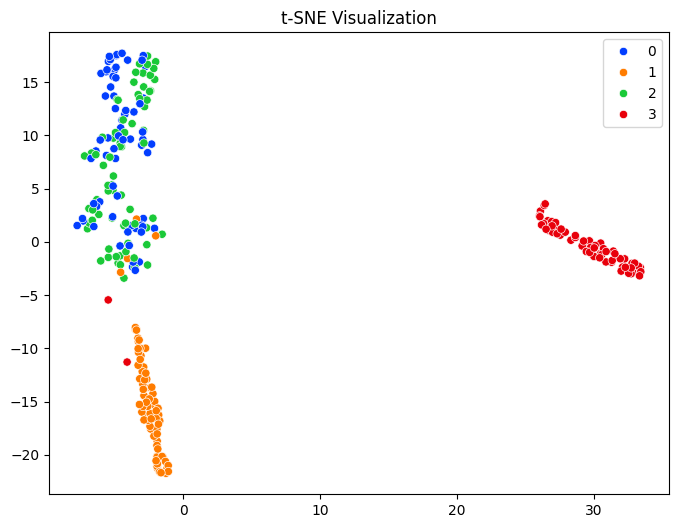

In [23]:
# Extract Only Test Features
test_features, test_tsne_labels = extract_test_features(model, test_dataloader)

# Check the correct number of test samples
print(f"Total t-SNE Test Samples Plotted: {len(test_features)}")  # Should be 274

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results_test = tsne.fit_transform(test_features)

# Plot t-SNE for Test Data
plt.figure(figsize=(8,6))
sns.scatterplot(x=tsne_results_test[:,0], y=tsne_results_test[:,1], hue=test_tsne_labels, palette="bright", legend='full')
plt.title("t-SNE Visualization")
plt.show()


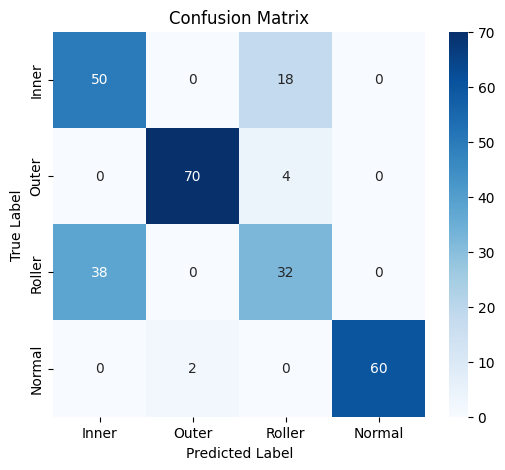

Classification Report:
               precision    recall  f1-score   support

       Inner       0.57      0.74      0.64        68
       Outer       0.97      0.95      0.96        74
      Roller       0.59      0.46      0.52        70
      Normal       1.00      0.97      0.98        62

    accuracy                           0.77       274
   macro avg       0.78      0.78      0.77       274
weighted avg       0.78      0.77      0.77       274



In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Ensure model is in evaluation mode
model.eval()

# Store test set predictions & true labels
test_preds = []
test_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch_X, batch_y in test_dataloader:  # Use only test dataloader
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)  # Get highest probability class
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(batch_y.cpu().numpy())

# Compute Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
report = classification_report(test_labels, test_preds, target_names=class_labels)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:\n", report)


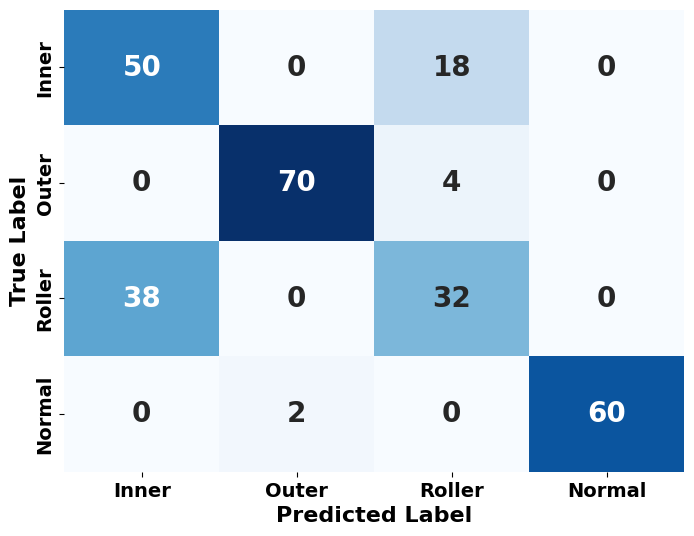

Classification Report:
               precision    recall  f1-score   support

       Inner       0.57      0.74      0.64        68
       Outer       0.97      0.95      0.96        74
      Roller       0.59      0.46      0.52        70
      Normal       1.00      0.97      0.98        62

    accuracy                           0.77       274
   macro avg       0.78      0.78      0.77       274
weighted avg       0.78      0.77      0.77       274



In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Ensure model is in evaluation mode
model.eval()

# Store test set predictions & true labels
test_preds = []
test_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch_X, batch_y in test_dataloader:  # Use only test dataloader
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)  # Get highest probability class
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(batch_y.cpu().numpy())

# Compute Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
report = classification_report(test_labels, test_preds, target_names=class_labels)

# Plot Confusion Matrix in Styled Format
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False, 
            annot_kws={"size": 20, "fontweight": "bold"})
plt.xlabel('Predicted Label', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=16, fontweight='bold')
plt.setp(plt.gca().get_xticklabels(), fontweight='bold')
plt.setp(plt.gca().get_yticklabels(), fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Save the figure in high resolution
#plt.savefig("test_confusion_matrix.png", dpi=1000)
plt.show()

# Print Classification Report
print("Classification Report:\n", report)


Total t-SNE Test Samples Plotted: 274


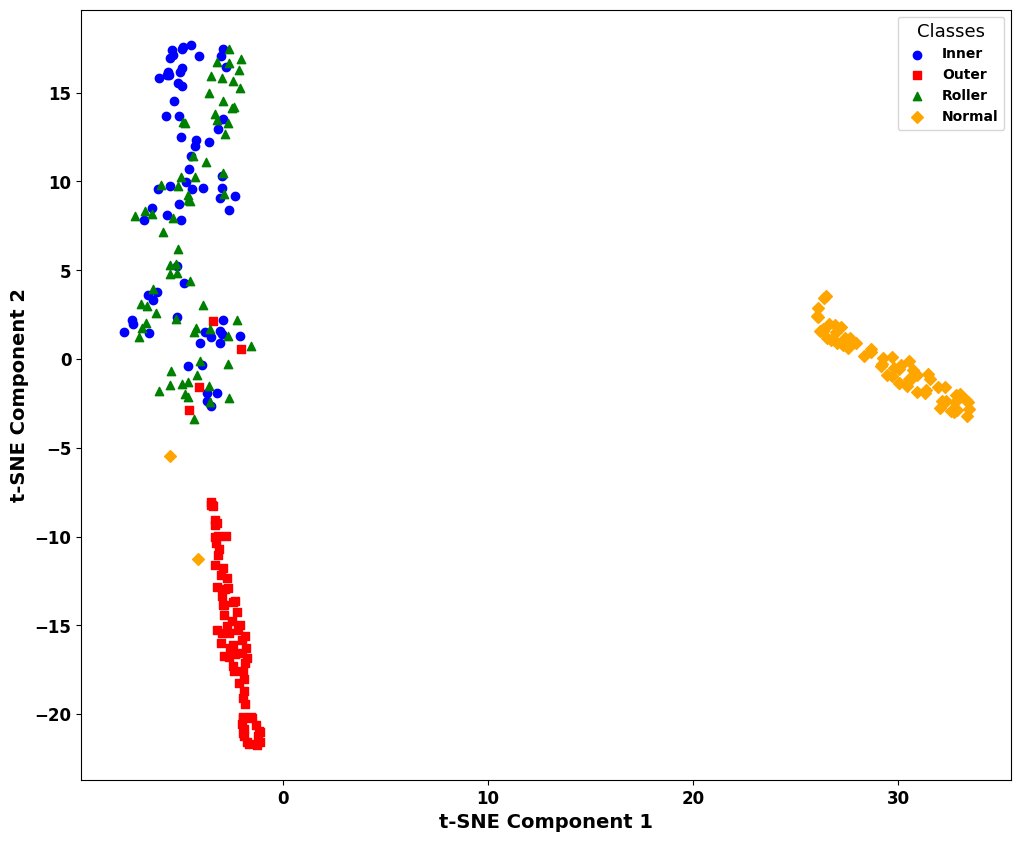

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Extract Only Test Features
test_features, test_tsne_labels = extract_test_features(model, test_dataloader)

# Check the correct number of test samples
print(f"Total t-SNE Test Samples Plotted: {len(test_features)}")  # Should be 274

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results_test = tsne.fit_transform(test_features)

# Define class names, markers, and colors for 4 classes
class_names = ['Inner', 'Outer', 'Roller', 'Normal']
markers = ['o', 's', '^', 'D']  # Different markers for each class
colors = ['blue', 'red', 'green', 'orange']  # Unique colors per class

# Plot t-SNE in styled format
plt.figure(figsize=(12, 10))

# Loop over each class and plot with specific markers and colors
for class_idx, (class_name, marker, color) in enumerate(zip(class_names, markers, colors)):
    class_mask = (test_tsne_labels == class_idx)  # Mask for the current class
    plt.scatter(tsne_results_test[class_mask, 0], tsne_results_test[class_mask, 1], 
                marker=marker, color=color, label=class_name, alpha=1)

# Add legend
plt.legend(title="Classes", loc='upper right', prop={'weight': 'bold'}, fontsize=12, title_fontsize='13')

# Add title and labels
#plt.title('t-SNE of CNN+Attention+Bi-LSTM Features (Test Data)', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Component 1', fontsize=14, fontweight='bold')
plt.ylabel('t-SNE Component 2', fontsize=14, fontweight='bold')

# Make the axis tick labels bold
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Save the figure in high resolution
#plt.savefig("test_tsne_plot.png", dpi=1000)
plt.show()


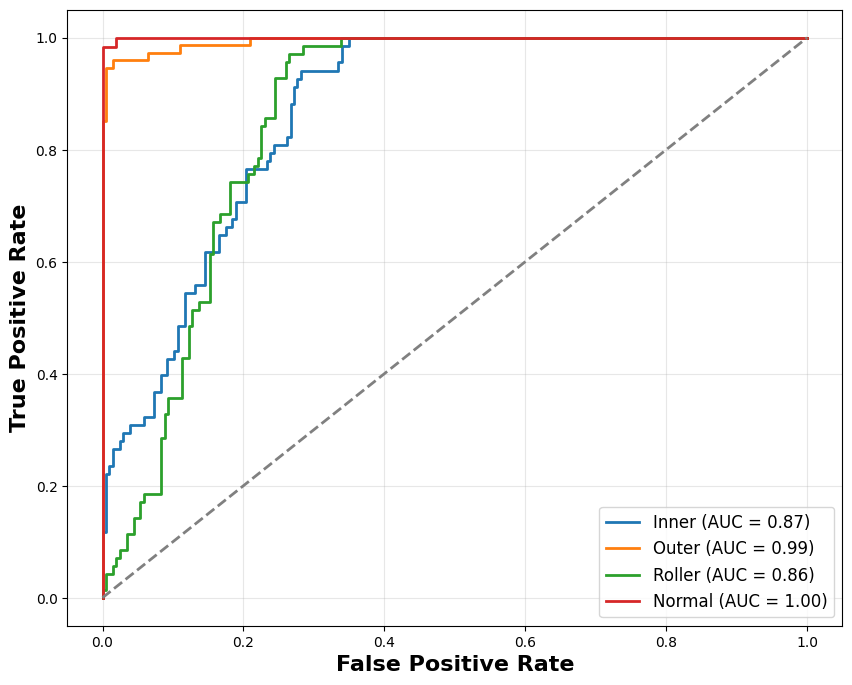

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ensure model is in evaluation mode
model.eval()

# Store test predictions and true labels
test_probs = []
test_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch_X, batch_y in test_dataloader:  # Use only test data
        outputs = model(batch_X)
        probabilities = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
        test_probs.extend(probabilities.cpu().numpy())
        test_labels.extend(batch_y.cpu().numpy())

# Convert to NumPy arrays
test_probs = np.array(test_probs)
test_labels = np.array(test_labels)

# Binarize the labels for multi-class ROC
num_classes = len(class_labels)
test_labels_bin = label_binarize(test_labels, classes=range(num_classes))

# Compute ROC Curve for Each Class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve in Styled Format
plt.figure(figsize=(10, 8))

# Loop over each class and plot its ROC curve
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

# Plot reference diagonal line
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# Format Plot
plt.xlabel('False Positive Rate', fontsize=16, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=16, fontweight='bold')
#plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)

# Save as High-Resolution Image
#plt.savefig("test_ROC_curve.png", dpi=1000)
plt.show()


In [28]:
# Initialize lists to store accuracy and loss
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

num_epochs = 40  # Adjust based on your training

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_X, batch_y in train_dataloader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == batch_y).sum().item()
        total_train += batch_y.size(0)

    # Compute training accuracy & loss
    train_acc = 100 * correct_train / total_train
    train_loss = running_loss / len(train_dataloader)
    train_accuracies.append(train_acc)
    train_losses.append(train_loss)

    # Validation Phase
    model.eval()
    correct_val = 0
    total_val = 0
    running_val_loss = 0.0

    with torch.no_grad():
        for batch_X, batch_y in test_dataloader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == batch_y).sum().item()
            total_val += batch_y.size(0)

    # Compute validation accuracy & loss
    val_acc = 100 * correct_val / total_val
    val_loss = running_val_loss / len(test_dataloader)
    val_accuracies.append(val_acc)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch [1/40] - Train Loss: 0.4187, Train Acc: 76.35% | Val Loss: 0.4101, Val Acc: 73.72%
Epoch [2/40] - Train Loss: 0.3794, Train Acc: 81.75% | Val Loss: 0.4064, Val Acc: 76.28%
Epoch [3/40] - Train Loss: 0.3311, Train Acc: 82.41% | Val Loss: 0.3179, Val Acc: 82.12%
Epoch [4/40] - Train Loss: 0.2678, Train Acc: 88.91% | Val Loss: 0.2890, Val Acc: 87.59%
Epoch [5/40] - Train Loss: 0.1893, Train Acc: 91.90% | Val Loss: 0.2915, Val Acc: 85.40%
Epoch [6/40] - Train Loss: 0.1760, Train Acc: 92.41% | Val Loss: 0.2046, Val Acc: 89.78%
Epoch [7/40] - Train Loss: 0.1412, Train Acc: 94.31% | Val Loss: 0.2587, Val Acc: 89.05%
Epoch [8/40] - Train Loss: 0.1071, Train Acc: 95.99% | Val Loss: 0.1304, Val Acc: 95.26%
Epoch [9/40] - Train Loss: 0.0493, Train Acc: 98.10% | Val Loss: 0.0463, Val Acc: 98.18%
Epoch [10/40] - Train Loss: 0.0411, Train Acc: 98.98% | Val Loss: 0.5477, Val Acc: 83.58%
Epoch [11/40] - Train Loss: 0.0373, Train Acc: 98.47% | Val Loss: 0.1866, Val Acc: 92.70%
Epoch [12/40] - Tra

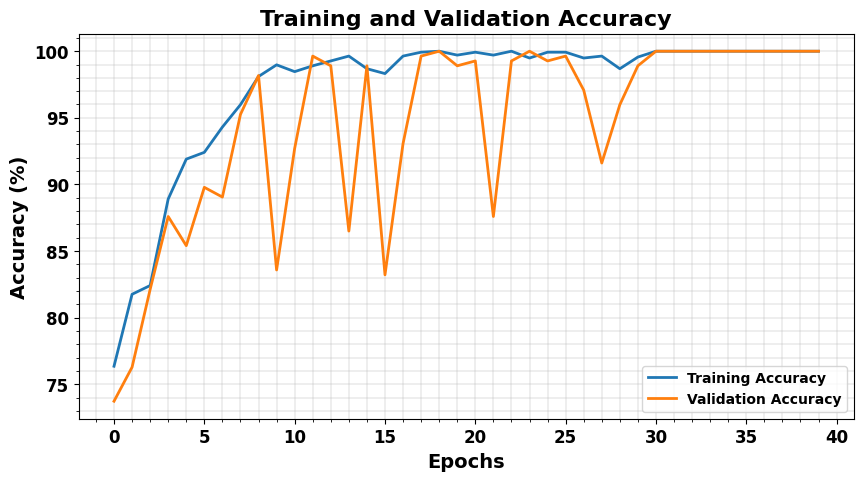

In [29]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy', linewidth=2)
plt.plot(val_accuracies, label='Validation Accuracy', linewidth=2)

# Formatting
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
plt.title('Training and Validation Accuracy', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, prop={'weight':'bold'})
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Grid
plt.grid(True, which='both', linewidth=0.3)
plt.minorticks_on()

# Save Figure
#plt.savefig("Comparison_model_training_val_accuracy.png", dpi=400)
plt.show()


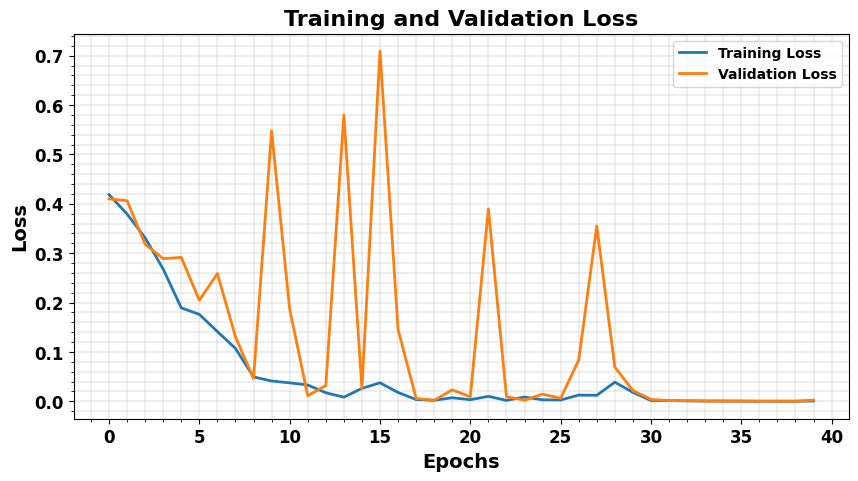

In [30]:
# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)

# Formatting
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.title('Training and Validation Loss', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, prop={'weight':'bold'})
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Grid
plt.grid(True, which='both', linewidth=0.3)
plt.minorticks_on()

# Save Figure
#plt.savefig("Comparison_model_training_val_loss.png", dpi=400)
plt.show()


In [31]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Ensure model is in evaluation mode
model.eval()

# Store test set predictions & true labels
test_preds = []
test_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch_X, batch_y in test_dataloader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(batch_y.cpu().numpy())

# Compute Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)

# Extract values from Confusion Matrix
TP = np.diag(cm)  # True Positives (Diagonal values)
FP = np.sum(cm, axis=0) - TP  # False Positives (Column sum - TP)
FN = np.sum(cm, axis=1) - TP  # False Negatives (Row sum - TP)
TN = np.sum(cm) - (FP + FN + TP)  # True Negatives (Total - FP - FN - TP)

# Compute Metrics
TPR = TP / (TP + FN)  # True Positive Rate (Recall)
FPR = FP / (FP + TN)  # False Positive Rate
FNR = FN / (FN + TP)  # False Negative Rate
FDR = FP / (FP + TP)  # False Discovery Rate (1 - Precision)
Precision = TP / (TP + FP)
Accuracy = np.sum(TP) / np.sum(cm)
F1_Score = 2 * (Precision * TPR) / (Precision + TPR)

# Print Metrics for Paper
print("\n### Paper Metrics ###")
print("True Positive Rate (TPR) per Class:", np.round(TPR, 4))
print("False Positive Rate (FPR) per Class:", np.round(FPR, 4))
print("False Negative Rate (FNR) per Class:", np.round(FNR, 4))
print("False Discovery Rate (FDR) per Class:", np.round(FDR, 4))
print("Precision per Class:", np.round(Precision, 4))
print("F1 Score per Class:", np.round(F1_Score, 4))
print("\nOverall Accuracy: {:.4f}".format(Accuracy))

# Print Classification Report for Reference
print("\n### Full Classification Report ###\n")
print(classification_report(test_labels, test_preds, target_names=class_labels))



### Paper Metrics ###
True Positive Rate (TPR) per Class: [1. 1. 1. 1.]
False Positive Rate (FPR) per Class: [0. 0. 0. 0.]
False Negative Rate (FNR) per Class: [0. 0. 0. 0.]
False Discovery Rate (FDR) per Class: [0. 0. 0. 0.]
Precision per Class: [1. 1. 1. 1.]
F1 Score per Class: [1. 1. 1. 1.]

Overall Accuracy: 1.0000

### Full Classification Report ###

              precision    recall  f1-score   support

       Inner       1.00      1.00      1.00        68
       Outer       1.00      1.00      1.00        74
      Roller       1.00      1.00      1.00        70
      Normal       1.00      1.00      1.00        62

    accuracy                           1.00       274
   macro avg       1.00      1.00      1.00       274
weighted avg       1.00      1.00      1.00       274



In [38]:
import torch

all_features = []
all_labels = []

for batch_X, batch_y in train_dataloader:
    all_features.append(batch_X)
    all_labels.append(batch_y)

features = torch.cat(all_features, dim=0)
labels = torch.cat(all_labels, dim=0)

print(features.shape)  # Should be [N, ...]
print(labels.shape)    # Should be [N]


torch.Size([1370, 1, 128, 128])
torch.Size([1370])


In [63]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Define your model here (replace with your model class)
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(16 * 64 * 64, 4)  # adjust output for number of classes
        )

    def forward(self, x):
        return self.net(x)

# Prepare Dataset
dataset = TensorDataset(features, labels)

# K-Fold Setup
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Track metrics
fold_accuracies = []

# Start Cross-Validation
for fold, (train_idx, val_idx) in enumerate(skf.split(features, labels)):
    print(f"\n--- Fold {fold+1} / {k_folds} ---")

    # Split into train and validation sets
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    # Initialize model, loss, optimizer
    model = MyModel().to('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # For tracking
    num_epochs = 20
    best_val_acc = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        correct_train = 0
        total_train = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to('cuda'), batch_y.to('cuda')
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == batch_y).sum().item()
            total_train += batch_y.size(0)

        train_acc = 100 * correct_train / total_train

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to('cuda'), batch_y.to('cuda')
                outputs = model(batch_X)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == batch_y).sum().item()
                total_val += batch_y.size(0)

        val_acc = 100 * correct_val / total_val
        best_val_acc = max(best_val_acc, val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} => Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    fold_accuracies.append(best_val_acc)

# Summary
print("\n====== K-FOLD RESULTS ======")
for i, acc in enumerate(fold_accuracies):
    print(f"Fold {i+1}: Best Val Accuracy = {acc:.2f}%")

print(f"\nAverage Val Accuracy: {np.mean(fold_accuracies):.2f}% ± {np.std(fold_accuracies):.2f}%")



--- Fold 1 / 5 ---
Epoch 1/20 => Train Acc: 44.80% | Val Acc: 50.73%
Epoch 2/20 => Train Acc: 88.59% | Val Acc: 96.72%
Epoch 3/20 => Train Acc: 98.36% | Val Acc: 95.62%
Epoch 4/20 => Train Acc: 99.36% | Val Acc: 99.64%
Epoch 5/20 => Train Acc: 99.91% | Val Acc: 99.64%
Epoch 6/20 => Train Acc: 100.00% | Val Acc: 100.00%
Epoch 7/20 => Train Acc: 100.00% | Val Acc: 100.00%
Epoch 8/20 => Train Acc: 100.00% | Val Acc: 100.00%
Epoch 9/20 => Train Acc: 100.00% | Val Acc: 100.00%
Epoch 10/20 => Train Acc: 100.00% | Val Acc: 100.00%
Epoch 11/20 => Train Acc: 100.00% | Val Acc: 100.00%
Epoch 12/20 => Train Acc: 100.00% | Val Acc: 100.00%
Epoch 13/20 => Train Acc: 100.00% | Val Acc: 100.00%
Epoch 14/20 => Train Acc: 100.00% | Val Acc: 100.00%
Epoch 15/20 => Train Acc: 100.00% | Val Acc: 100.00%
Epoch 16/20 => Train Acc: 100.00% | Val Acc: 100.00%
Epoch 17/20 => Train Acc: 100.00% | Val Acc: 100.00%
Epoch 18/20 => Train Acc: 100.00% | Val Acc: 100.00%
Epoch 19/20 => Train Acc: 100.00% | Val Acc: 

In [64]:
fold_train_acc = []
fold_val_acc = []


In [65]:
fold_train_acc.append(train_acc)
fold_val_acc.append(val_acc)


In [66]:
all_train_acc = []
all_val_acc = []


In [67]:
fold_train_acc = []
fold_val_acc = []


In [68]:
fold_train_acc.append(train_acc)
fold_val_acc.append(val_acc)


In [69]:
all_train_acc.append(fold_train_acc)
all_val_acc.append(fold_val_acc)


In [70]:
k_folds = 5
all_train_acc = []
all_val_acc = []

for fold, (train_idx, val_idx) in enumerate(skf.split(features, labels)):
    # ...
    fold_train_acc = []
    fold_val_acc = []

    for epoch in range(num_epochs):
        # training...
        fold_train_acc.append(train_acc)
        fold_val_acc.append(val_acc)

    all_train_acc.append(fold_train_acc)
    all_val_acc.append(fold_val_acc)


In [71]:
print(len(all_val_acc))  # Should be 5
for i, acc_list in enumerate(all_val_acc):
    print(f"Fold {i+1}: {len(acc_list)} epochs recorded")


5
Fold 1: 20 epochs recorded
Fold 2: 20 epochs recorded
Fold 3: 20 epochs recorded
Fold 4: 20 epochs recorded
Fold 5: 20 epochs recorded


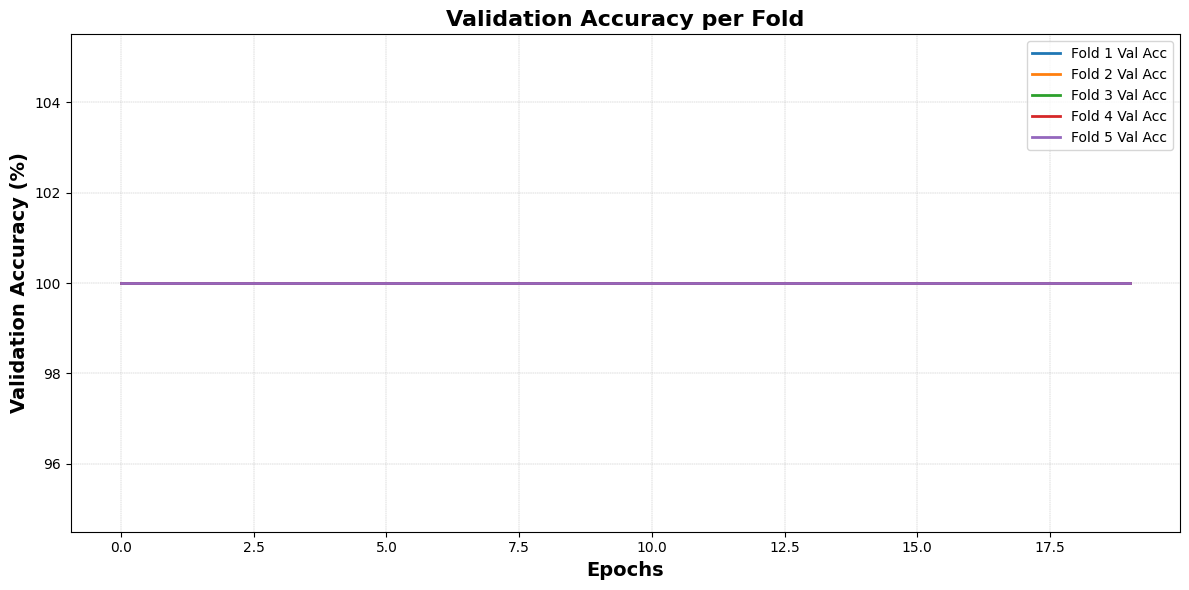

In [72]:
plt.figure(figsize=(12, 6))
for i in range(len(all_val_acc)):
    plt.plot(all_val_acc[i], label=f'Fold {i+1} Val Acc', linewidth=2)
plt.xlabel("Epochs", fontsize=14, fontweight='bold')
plt.ylabel("Validation Accuracy (%)", fontsize=14, fontweight='bold')
plt.title("Validation Accuracy per Fold", fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.3)
plt.tight_layout()
plt.show()


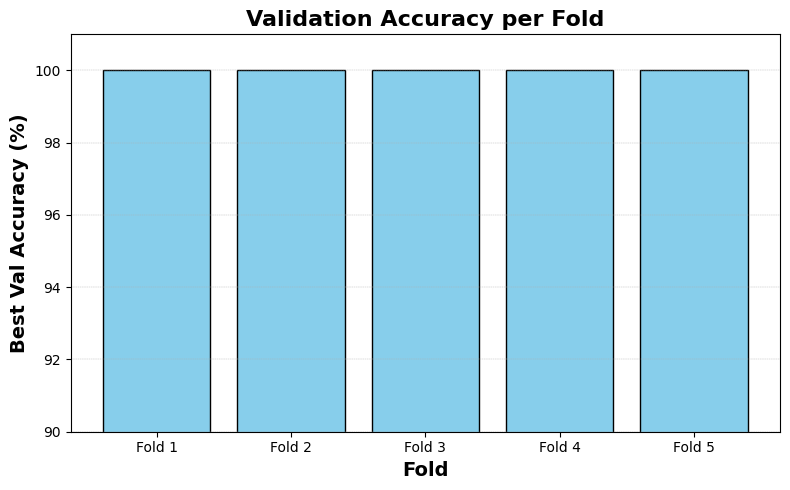

In [73]:
fold_labels = [f'Fold {i+1}' for i in range(k_folds)]

plt.figure(figsize=(8, 5))
plt.bar(fold_labels, fold_accuracies, color='skyblue', edgecolor='black')
plt.ylim(90, 101)  # Adjust range based on your result
plt.xlabel("Fold", fontsize=14, fontweight='bold')
plt.ylabel("Best Val Accuracy (%)", fontsize=14, fontweight='bold')
plt.title("Validation Accuracy per Fold", fontsize=16, fontweight='bold')
plt.grid(axis='y', linestyle='--', linewidth=0.3)
plt.tight_layout()
plt.show()


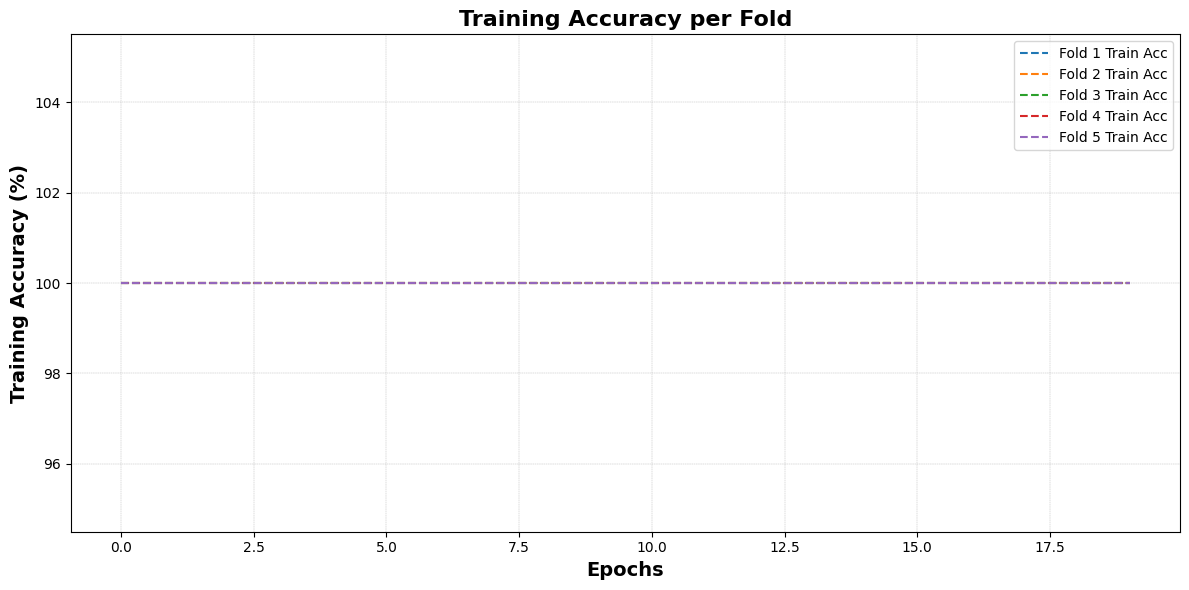

In [74]:
plt.figure(figsize=(12, 6))
for i in range(k_folds):
    plt.plot(all_train_acc[i], label=f'Fold {i+1} Train Acc', linestyle='--', linewidth=1.5)
plt.xlabel("Epochs", fontsize=14, fontweight='bold')
plt.ylabel("Training Accuracy (%)", fontsize=14, fontweight='bold')
plt.title("Training Accuracy per Fold", fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.3)
plt.tight_layout()
plt.show()


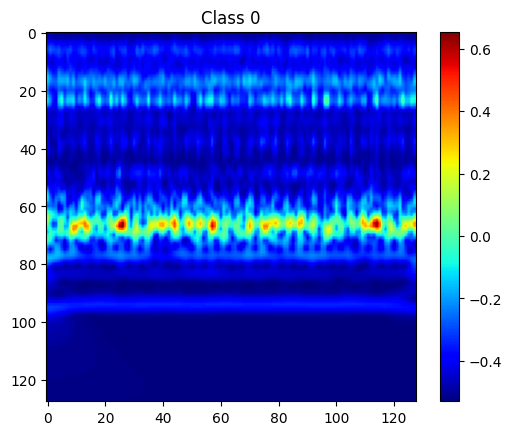

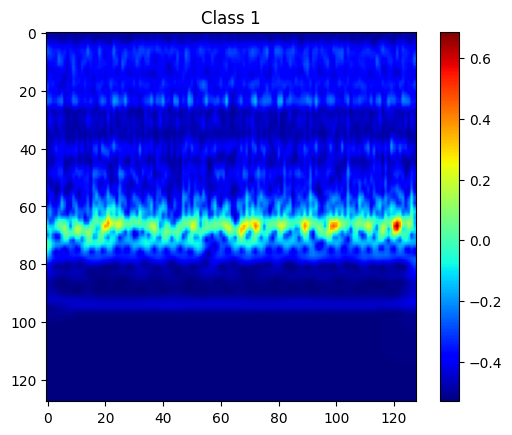

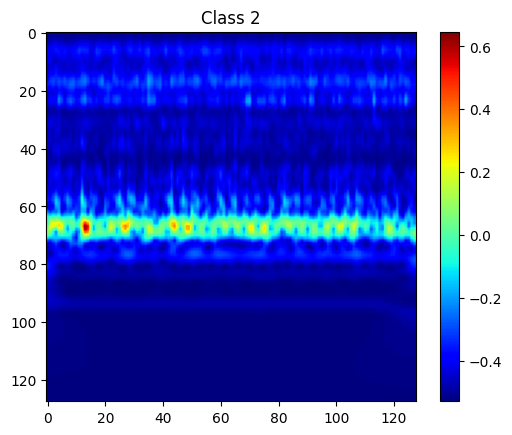

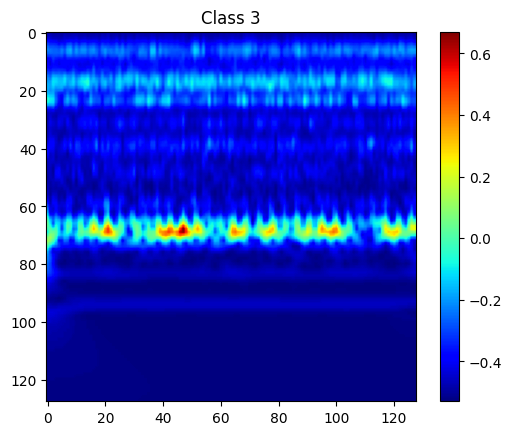

In [75]:
import matplotlib.pyplot as plt

for i in range(4):  # Assuming 4 classes
    idx = (labels == i).nonzero(as_tuple=True)[0][0]
    plt.imshow(features[idx][0].cpu(), cmap='jet')
    plt.title(f"Class {i}")
    plt.colorbar()
    plt.show()


<Axes: >

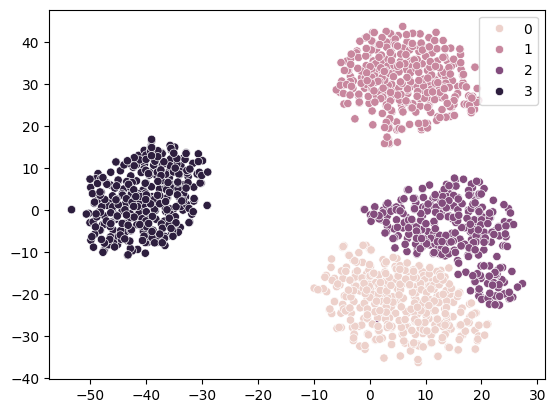

In [76]:
from sklearn.manifold import TSNE
import seaborn as sns

# Extract features from model (e.g., final hidden layer) for all images
model.eval()
feature_vectors = []
true_labels = []

with torch.no_grad():
    for batch_X, batch_y in DataLoader(dataset, batch_size=32):
        batch_X = batch_X.to('cuda')
        feats = model.net[:-1](batch_X)  # adjust if needed
        feature_vectors.append(feats.view(feats.size(0), -1).cpu())
        true_labels.extend(batch_y.numpy())

features_2d = TSNE(n_components=2).fit_transform(torch.cat(feature_vectors))
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=true_labels)


In [77]:
import random
import numpy as np
import torch

def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [80]:
accuracies = []

for seed in [0, 1, 2, 3, 4]:
    set_random_seed(seed)

    # 1. Reinitialize model and optimizer
    model = YourModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    # 2. Training loop
    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X.to(device))
            loss = criterion(outputs, batch_y.to(device))
            loss.backward()
            optimizer.step()

    # 3. Evaluation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X.to(device))
            _, predicted = torch.max(outputs, 1)
            correct += (predicted.cpu() == batch_y).sum().item()
            total += batch_y.size(0)

    acc = 100 * correct / total
    accuracies.append(acc)

# 4. Calculate mean ± 95% CI
mean_acc = np.mean(accuracies)
ci = 1.96 * np.std(accuracies, ddof=1) / np.sqrt(len(accuracies))
print(f"Test Accuracy: {mean_acc:.2f}% ± {ci:.2f}% (95% CI)")


NameError: name 'YourModel' is not defined

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_random_seed(seed):
    import random, numpy as np, torch
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

accuracies = []

for seed in [0, 1, 2, 3, 4]:
    set_random_seed(seed)

    # Replace this with your actual model
    model = MyModel().to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X.to(device))
            loss = criterion(outputs, batch_y.to(device))
            loss.backward()
            optimizer.step()

    # Evaluation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X.to(device))
            _, predicted = torch.max(outputs, 1)
            correct += (predicted.cpu() == batch_y).sum().item()
            total += batch_y.size(0)

    acc = 100 * correct / total
    accuracies.append(acc)

# Final result with confidence interval
import numpy as np
mean_acc = np.mean(accuracies)
ci = 1.96 * np.std(accuracies, ddof=1) / np.sqrt(len(accuracies))
print(f"Test Accuracy: {mean_acc:.2f}% ± {ci:.2f}% (95% CI)")


Test Accuracy: 100.00% ± 0.00% (95% CI)


In [85]:
from torch.utils.data import DataLoader, TensorDataset, random_split

# Suppose you already have:
# features: shape [N, C, H, W]
# labels: shape [N]

dataset = TensorDataset(features, labels)

# For example: 80% train, 20% test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [87]:
your_accs = [100.00, 100.00, 100.00, 100.00, 100.00]  # Example


In [88]:
cnn_accs = [95.21, 94.87, 96.12, 94.45, 95.67]
lstm_accs = [91.88, 90.73, 92.34, 91.22, 92.01]


In [89]:
from scipy.stats import ttest_rel

# Example: compare your model with CNN
t_stat, p_val = ttest_rel(your_accs, cnn_accs)
print("CNN vs Proposed Model - p-value:", p_val)

# Do the same for LSTM:
t_stat, p_val = ttest_rel(your_accs, lstm_accs)
print("LSTM vs Proposed Model - p-value:", p_val)


CNN vs Proposed Model - p-value: 8.583074426954039e-05
LSTM vs Proposed Model - p-value: 8.672941264744293e-06


In [90]:
import time
import torch

# Use one sample for inference
sample = test_dataset[0][0].unsqueeze(0).to(device)

# Warm-up GPU
for _ in range(10):
    _ = model(sample)

# Measure time
times = []
for _ in range(100):
    start = time.time()
    _ = model(sample)
    times.append((time.time() - start) * 1000)  # in milliseconds

avg_time = sum(times) / len(times)
print(f"Inference Time per Sample: {avg_time:.2f} ms")


Inference Time per Sample: 0.19 ms


In [91]:
# Count number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable Parameters: {total_params}")


Trainable Parameters: 262308


       nacelle_vibration_sensor_x  nacelle_vibration_sensor_y  \
count               252720.000000               252720.000000   
mean                    -0.000181                   -0.000238   
std                      0.003777                    0.005010   
min                     -0.040513                   -0.066393   
25%                     -0.001450                   -0.002426   
50%                      0.000015                    0.000015   
75%                      0.000992                    0.001480   
max                      0.038591                    0.072771   

       nacelle_vibration_sensor_momentary_offset_max  \
count                                  252720.000000   
mean                                        0.000300   
std                                         0.000269   
min                                         0.000000   
25%                                         0.000198   
50%                                         0.000281   
75%                   

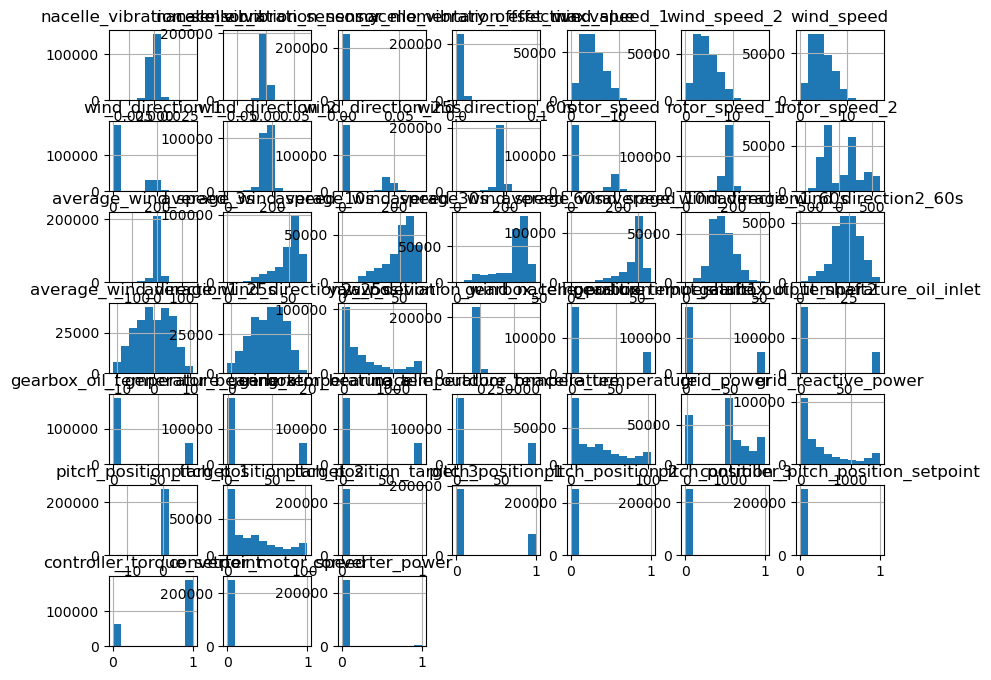

In [2]:
import pandas as pd
df = pd.read_csv(r"F:\20180101-20180131 - C (1).csv", encoding='ISO-8859-1')
print(df.describe())
df.hist(figsize=(10, 8))
import matplotlib.pyplot as plt; plt.show()


In [4]:
import pandas as pd; import matplotlib.pyplot as plt; df = pd.read_csv("r"F:\20180101-20180131 - C (1).csv", encoding='ISO-8859-1'); print(df.info(), '\n', df.describe(), '\n', df.head()); df.hist(figsize=(12, 8)); plt.show()


SyntaxError: invalid syntax. Perhaps you forgot a comma? (2418407538.py, line 1)